<a href="https://colab.research.google.com/github/ycu-engine/kaggle/blob/main/nlp-getting-started/yuta-ura-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggleセットアップ

1. KaggleのAPIキーのアップロードをする

参考：https://kopaprin.hatenadiary.jp/entry/2020/05/07/083000

In [1]:
from google.colab import files
files.upload()
print('upload success')

Saving kaggle.json to kaggle.json
upload success


2. Kaggle API Keyの設定

In [2]:
!mkdir -p ~/.kaggle
!chmod 600 kaggle.json
!cp kaggle.json ~/.kaggle/

3. kaggleライブラリのインストール

In [3]:
!pip install kaggle

## KaggleAPIのレシピ

```
kaggle competitions {list, files, download, submit, submissions, leaderboard}
kaggle datasets {list, files, download, create, version, init}
kaggle kernels {list, init, push, pull, output, status}
kaggle config {view, set, unset}
```
詳しくは公式のドキュメントを参照：https://github.com/Kaggle/kaggle-api

# データの準備

In [4]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 36.3MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 56.9MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.9MB/s]


In [5]:
import pandas as pd

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# 前処理

[前回](https://github.com/ycu-engine/kaggle/blob/main/nlp-getting-started/yuta-ura1.ipynb)に基礎分析等を済ませているので、いきなり前処理から入る

- textからURLの除去
- textからメンションの除去
- textからハッシュタグのハッシュのみ除去

を行う

In [6]:
import re

import numpy as np

In [7]:
def remove_url(text: str):
    return re.sub(r'https?://[a-zA-Z0-9./_\-]+', '', text)

def remove_mentions(text: str):
    return re.sub(r'@[a-zA-Z0-9_\-]+', '', text)

def remove_hashtags(text: str):
    return text.replace('#', '')

def clean_text(text: str):
    return remove_url(remove_mentions(remove_hashtags(text)))

train_df['cleaned_text'] = train_df.text.apply(clean_text)
train_df['cleaned_text']

0       Our Deeds are the Reason of this earthquake Ma...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive wildfires evacuation ord...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609      The out of control wild fires in California ...
7610          M1.94 [01:04 UTC]?5km S of Volcano Hawaii. 
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: cleaned_text, Length: 7613, dtype: object

# PyTorch-Transformersでを使った前処理

In [8]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses tokenizers transformers

     |████████████████████████████████| 102kB 5.2MB/s 
     |████████████████████████████████| 1.2MB 13.1MB/s 
     |████████████████████████████████| 890kB 24.6MB/s 
     |████████████████████████████████| 3.2MB 38.5MB/s 
     |████████████████████████████████| 2.0MB 41.1MB/s 
     |████████████████████████████████| 7.3MB 42.7MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
  Created wheel for boto3: filename=boto3-1.17.39-py2.py3-none-any.whl size=128779 sha256=562efdca3e3e205c72dd36a119d80f3e92e98fe045b29a198b89304bed956413
  Stored in directory: /root/.cache/pip/wheels/c6/45/42/48c8efe6fd9d2a4fc10ebd8fb742853526f29aa380514714b5
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=06e1613203d44b6b93e1fc41b6aa182428283da31eb700bd473001f0e292978a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built boto3 sacremoses
ERROR: botocore 1.20.39 has requirement urlli

In [65]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## tokenizerの読みこみ

In [11]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased-finetuned-mrpc')

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/master.zip" to /root/.cache/torch/hub/master.zip


## modelの読み込み

In [29]:
model = torch.hub.load('huggingface/pytorch-transformers', 'modelForSequenceClassification', 'bert-base-uncased')
model.to(device)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weight

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## configの読み込み

In [13]:
config = torch.hub.load('huggingface/pytorch-transformers', 'config', 'bert-base-uncased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master


## 訓練データを訓練用と検証用に分割

In [38]:
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(train_df.cleaned_text, train_df.target, test_size=0.1, stratify=train_df.target)

In [57]:
class DisasterTweetDataset(Dataset):

    def __init__(self, tweets, targets, name = 'train'):
        super().__init__()
        self.name = name
        self.tweets = tweets
        self.targets = targets
        '''
        Tokenize all of the captions and map the tokens to thier word IDs, and get respective attention masks.
        '''
        encoded_data = tokenizer(
            self.tweets,
            add_special_tokens=True,
            max_length=32,
            truncation=True,
            padding=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        self.input_ids, self.attention_masks = encoded_data['input_ids'], encoded_data['attention_mask']
        
        
    
    def __getitem__(self,index): 
        '''
        For Captions, Input ids and Attention mask
        '''
        tweet = self.tweets[index]
        input_id = self.input_ids[index]
        attention_masks = self.attention_masks[index]
        
        '''
        For Labels during training
        '''      
        if self.name == 'train' or self.name == 'valid' :
            label = float(self.targets[index])
            return tweet, input_id, attention_masks, torch.as_tensor(label).long()
        else:
            return tweet, input_id, attention_masks
        
        
  
    def __len__(self):
        return len(self.tweets)

In [76]:
train_dataset = DisasterTweetDataset(x_train_s.to_list(), y_train_s.to_list(), name='train')
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32, num_workers=4, pin_memory=True)

validation_dataset = DisasterTweetDataset(x_test_s.to_list(), y_test_s.to_list(), name = 'valid')
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=32, num_workers=4, pin_memory=True)

test_dataset = DisasterTweetDataset(test_df.text.apply(clean_text).to_list(), None, name = 'test')
test_dataloader = DataLoader(test_dataset, shuffle= False, batch_size=1, num_workers=4, pin_memory=True)

In [63]:
def train(data_loader, valid_loader, criterion, optimizer, lr_scheduler, modelpath, device, epochs):
    model.train()

    train_loss= []
    valid_loss = []
    valid_acc = []
    for epoch in range(epochs):
        avg_loss = 0.0
        for batch_num, (tweet, input_id, attention_masks, target) in enumerate(data_loader):
            input_ids, attention_masks, target = input_id.to(device), attention_masks.to(device), target.to(device)

            loss, logits = model(
                input_ids, 
                token_type_ids=None, 
                attention_mask=attention_masks, 
                labels=target,
                return_dict=False
            )
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            avg_loss += loss.item()
            lr_scheduler.step()                                

        training_loss = avg_loss / len(data_loader)

        print('Epoch: ', epoch+1)            
        print('training loss = ', training_loss)
        train_loss.append(training_loss)

        validation_loss, top1_acc = test_classify(model, valid_loader, criterion, device)
        valid_loss.append(validation_loss)
        valid_acc.append(top1_acc)

        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
        }, modelpath)
    return train_loss, valid_loss, valid_acc

'''
Function to perform inference on validation set
Returns: validation loss, top1 accuracy
'''
def test_classify(model, valid_loader, criterion, device):
    model.eval()
    test_loss = []
    top1_accuracy = 0
    total = 0

    for batch_num, (tweet, input_id, attention_masks, target) in enumerate(valid_loader):
        input_ids, attention_masks, target = input_id.to(device), attention_masks.to(device), target.to(device)
        loss, logits = model(
            input_ids, 
            token_type_ids=None, 
            attention_mask=attention_masks, 
            labels=target,
            return_dict=False
        )

        test_loss.extend([loss.item()] * input_id.size()[0])
        
        predictions = F.softmax(logits, dim=1)

        _, top1_pred_labels = torch.max(predictions,1)
        top1_pred_labels = top1_pred_labels.view(-1)
        
        top1_accuracy += torch.sum(torch.eq(top1_pred_labels, target)).item()
        total += len(target)

    print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}'.format(np.mean(test_loss), top1_accuracy/total))
        
    return np.mean(test_loss), top1_accuracy/total

パラメータ

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
num_Epochs = 4
total_steps = len(train_dataloader) * num_Epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,  num_training_steps = total_steps)

In [64]:
modelname = 'BERT'
modelpath = 'saved_checkpoint_'+modelname

train_loss, valid_loss, valid_acc = train(
    train_dataloader,
    validation_dataloader,
    criterion,
    optimizer,
    lr_scheduler,
    modelpath,
    device,
    epochs=num_Epochs
)

Epoch:  1
training loss =  0.631537935068441
Validation Loss: 0.5913	Top 1 Validation Accuracy: 0.6903
Epoch:  2
training loss =  0.5523474248342736
Validation Loss: 0.5455	Top 1 Validation Accuracy: 0.7100
Epoch:  3
training loss =  0.4483783466178317
Validation Loss: 0.5449	Top 1 Validation Accuracy: 0.7375
Epoch:  4
training loss =  0.3978043185417042
Validation Loss: 0.5449	Top 1 Validation Accuracy: 0.7375


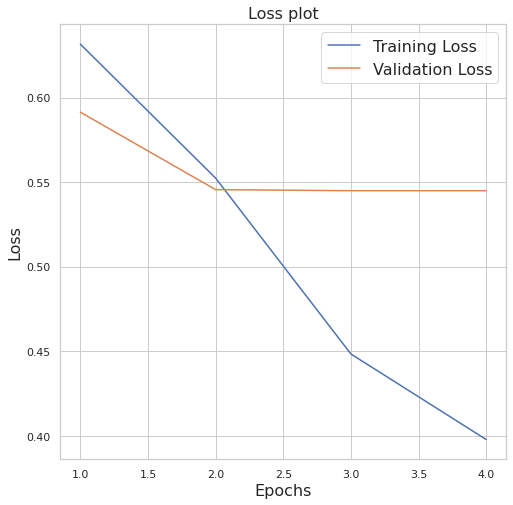

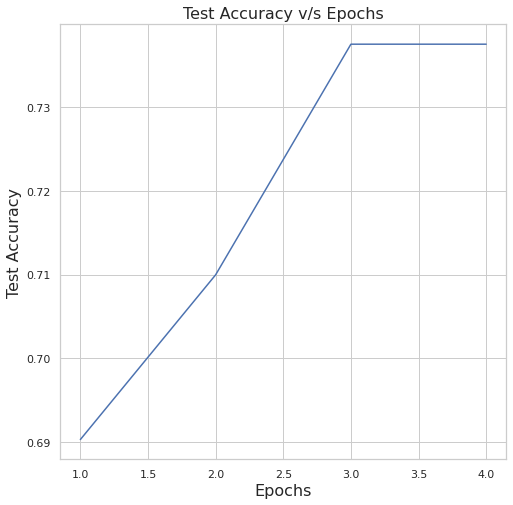

In [66]:
def plot_loss(epochs, train_loss, test_loss, title):
    plt.figure(figsize=(8,8))
    x = np.arange(1,epochs+1)
    plt.plot(x, train_loss, label = 'Training Loss')
    plt.plot(x, test_loss, label = 'Validation Loss')
    plt.xlabel('Epochs', fontsize =16)
    plt.ylabel('Loss', fontsize =16)
    plt.title(title,fontsize =16)
    plt.legend(fontsize=16)
    
    
def plot_acc(epochs,test_acc):
    plt.figure(figsize=(8,8))
    x = np.arange(1,epochs+1)
    plt.plot(x, test_acc)
    plt.xlabel('Epochs', fontsize =16)
    plt.ylabel('Test Accuracy', fontsize =16)
    plt.title('Test Accuracy v/s Epochs',fontsize =16)
    
    
sns.set_style("whitegrid")
plot_loss(num_Epochs, train_loss, valid_loss, title='Loss plot')
plot_acc(num_Epochs, valid_acc)

In [67]:
def predict(test_loader, device):
    model.eval()
    target = []
    for batch_num, (captions, input_id, attention_masks) in enumerate(test_loader):
        input_ids, attention_masks = input_id.to(device), attention_masks.to(device)
        output_dictionary = model(
            input_ids, 
            token_type_ids=None, 
            attention_mask=attention_masks, 
            return_dict=True
        )
        
        predictions = F.softmax(output_dictionary['logits'], dim=1)
        _, top1_pred_labels = torch.max(predictions,1)
        top1_pred_labels = top1_pred_labels.item()        
        target.append(top1_pred_labels)
    return pd.DataFrame({'id': test_df.id, 'target': target})
        
pred_df = predict(test_dataloader, device)

In [68]:
pred_df.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [70]:
pred_df.to_csv('submission.csv', index=False)

In [71]:
!kaggle competitions submit nlp-getting-started -f submission.csv -m "Bertを使って分類"

100% 22.2k/22.2k [00:02<00:00, 7.92kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

In [72]:
!kaggle competitions submissions nlp-getting-started

fileName               date                 description  status    publicScore  privateScore  
---------------------  -------------------  -----------  --------  -----------  ------------  
submission.csv         2021-03-27 10:57:22  Bertを使って分類   complete  0.72479      None          
sample_submission.csv  2021-03-14 15:41:49  None         complete  0.57033      None          
submission_1 (1).csv   2021-03-14 15:40:46               complete  0.51302      None          
submission_1.csv       2021-03-14 15:39:34  None         error     None         None          


スコア：0.72479

# locationの値をTweetに組み込んで同様に分析してみる。

In [74]:
x_train_s2, x_test_s2, y_train_s2, y_test_s2 = train_test_split(
    train_df.location.fillna('') + train_df.cleaned_text,
    train_df.target,
    test_size=0.1,
    stratify=train_df.target
)

In [77]:
train_dataset2 = DisasterTweetDataset(x_train_s2.to_list(), y_train_s2.to_list(), name='train')
train_dataloader2 = DataLoader(train_dataset2, shuffle=True, batch_size=32, num_workers=4, pin_memory=True)

validation_dataset2 = DisasterTweetDataset(x_test_s2.to_list(), y_test_s2.to_list(), name = 'valid')
validation_dataloader2 = DataLoader(validation_dataset2, shuffle=True, batch_size=32, num_workers=4, pin_memory=True)

test_dataset2 = DisasterTweetDataset((test_df.location.fillna('') + test_df.text.apply(clean_text)).to_list(), None, name = 'test')
test_dataloader2 = DataLoader(test_dataset2, shuffle= False, batch_size=1, num_workers=4, pin_memory=True)

In [79]:
modelname = 'BERT2'
modelpath = 'saved_checkpoint_'+modelname

train_loss2, valid_loss2, valid_acc2 = train(
    train_dataloader2,
    validation_dataloader2,
    criterion,
    optimizer,
    lr_scheduler,
    modelpath,
    device,
    epochs=num_Epochs
)

Epoch:  1
training loss =  0.5290372528309046
Validation Loss: 0.4526	Top 1 Validation Accuracy: 0.7927
Epoch:  2
training loss =  0.4780517826246661
Validation Loss: 0.4526	Top 1 Validation Accuracy: 0.7927
Epoch:  3
training loss =  0.47598928684412045
Validation Loss: 0.4526	Top 1 Validation Accuracy: 0.7927
Epoch:  4
training loss =  0.475341089658959
Validation Loss: 0.4526	Top 1 Validation Accuracy: 0.7927


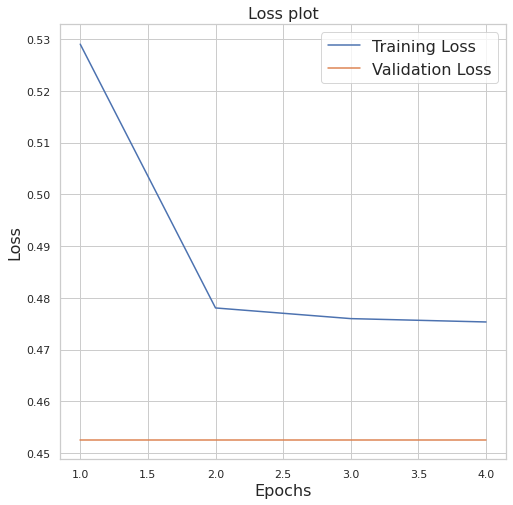

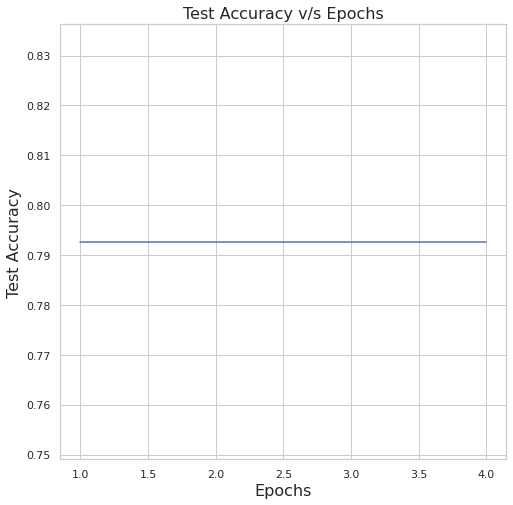

In [80]:
sns.set_style("whitegrid")
plot_loss(num_Epochs, train_loss2, valid_loss2, title='Loss plot')
plot_acc(num_Epochs, valid_acc2)

In [85]:
pred_df2 = predict(test_dataloader2, device)
pred_df2.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [86]:
pred_df2.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [87]:
pred_df2.to_csv('submission2.csv', index=False)
!kaggle competitions submit nlp-getting-started -f submission2.csv -m "Bertを使って分類２"
!kaggle competitions submissions nlp-getting-started

100% 22.2k/22.2k [00:03<00:00, 6.95kB/s]
Successfully submitted to Natural Language Processing with Disaster TweetsWarning: Looks like you're using an outdated API Version, please consider updating (server 1.5.12 / client 1.5.4)
fileName               date                 description  status    publicScore  privateScore  
---------------------  -------------------  -----------  --------  -----------  ------------  
submission2.csv        2021-03-27 11:14:56  Bertを使って分類２  complete  0.71805      None          
submission.csv         2021-03-27 10:57:22  Bertを使って分類   complete  0.72479      None          
sample_submission.csv  2021-03-14 15:41:49  None         complete  0.57033      None          
submission_1 (1).csv   2021-03-14 15:40:46               complete  0.51302      None          
submission_1.csv       2021-03-14 15:39:34  None         error     None         None          
